In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np

In [2]:
df=pd.read_csv(r'2004 to 2007 comple.csv')
df

,DATE,RAINFALL,FLOW (M3/S),FLOW-OBSERVED (M3/S)
0,9-Mar-04,0.1590,3990,4281
1,10-Mar-04,1.1065,3990,4270
2,11-Mar-04,0.0000,3990,4260
3,12-Mar-04,0.0000,3990,4249
4,13-Mar-04,0.0000,3990,4238
...,...,...,...,...
1448,25-Feb-08,0.0205,4304,3705
1449,26-Feb-08,0.0000,4294,3709
1450,27-Feb-08,0.0000,4296,3712
1451,28-Feb-08,0.0000,4288,3716


In [3]:
df.index=pd.to_datetime(df['DATE'])
df.head()

C:\Users\SHANTO-PC\AppData\Local\Temp\ipykernel_13752\2451772597.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index=pd.to_datetime(df['DATE'])


,DATE,RAINFALL,FLOW (M3/S),FLOW-OBSERVED (M3/S)
DATE,,,,
2004-03-09,9-Mar-04,0.1590,3990,4281
2004-03-10,10-Mar-04,1.1065,3990,4270
2004-03-11,11-Mar-04,0.0000,3990,4260
2004-03-12,12-Mar-04,0.0000,3990,4249
2004-03-13,13-Mar-04,0.0000,3990,4238


<Axes: xlabel='DATE'>

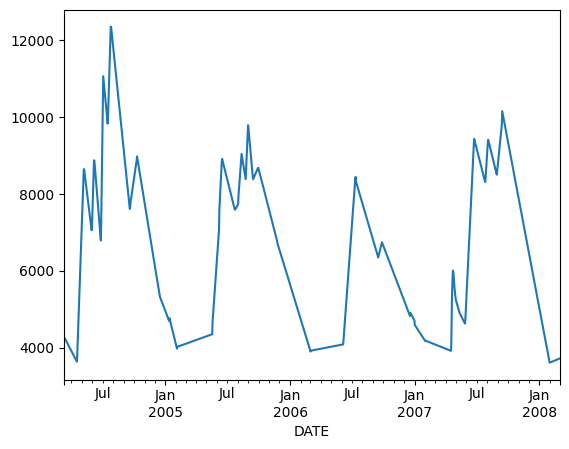

In [4]:
flow=df['FLOW-OBSERVED (M3/S)'[:100]]
flow.plot()

In [ ]:
def df_to_x_y(df, window_size=3):
    df_as_np=df.to_numpy()
    x=[]
    y=[]
    for i in range (len(df_as_np)-window_size):
        row=[[a] for a in df_as_np[i:i+3]]
        x.append(row)
        label= df_as_np[i+3]
        y.append(label)
    return np.array(x), np.array(y)

In [ ]:
Window=3
x,y= df_to_x_y(flow,Window)
x.shape, y.shape

((1452, 1, 1), (1452,))

In [7]:
x_train, y_train=x[:],y[:]
x_val, y_val=x[1000:],y[1000:]
# x_test, y_test=x[1000:],y[1000:]

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

models= Sequential()
models.add(InputLayer((50,1)))
models.add(LSTM(1028))
models.add(Dense(512,'relu'))
models.add(Dense(256,'relu'))
models.add(Dense(128,'relu'))
models.add(Dense(64,'relu'))
models.add(Dense(32,'relu'))
models.add(Dense(1,'linear'))

models.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1028)           │     4,235,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,936,801 (18.83 MB)

 Trainable params: 4,936,801 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cp= ModelCheckpoint('models/.keras', save_best_only=True)
models.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=.0001),metrics=[RootMeanSquaredError()])

In [10]:
csv=tf.keras.callbacks.CSVLogger(
   '2004 to 2007 comple.csv',  append=True)

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

models.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=200, callbacks=[cp,csv,early_stop])

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 44711652.0000 - root_mean_squared_error: 6686.3213 - val_loss: 41911676.0000 - val_root_mean_squared_error: 6473.9229
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 44074044.0000 - root_mean_squared_error: 6638.3076 - val_loss: 40838484.0000 - val_root_mean_squared_error: 6390.4995
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 42278788.0000 - root_mean_squared_error: 6501.6021 - val_loss: 34937132.0000 - val_root_mean_squared_error: 5910.7642
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 33882016.0000 - root_mean_squared_error: 5817.0400 - val_loss: 17645462.0000 - val_root_mean_squared_error: 4200.6504
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 13968589.0000 - root_mean_squared_error: 3714.6501 - val_loss: 4480375.5000 - val_root_mean_squared_error: 2116.6897
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4220796.0000 - root_mean_squared_error: 2053.7654 -

In [11]:
from tensorflow.keras.models import load_model

models=load_model('models/.keras')

In [12]:
train= models.predict(x_train).flatten()
results=pd.DataFrame(data={"Actuals":y_train, "Trained Prediction": train,})
results

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Actuals,Trained Prediction
0,4270,4223.980469
1,4260,4211.701660
2,4249,4200.533691
3,4238,4188.243164
4,4220,4175.947266
...,...,...
1447,3705,3568.980713
1448,3709,3573.546631
1449,3712,3578.112305
1450,3716,3581.535889


In [14]:
results.to_excel("simulated.xlsx")

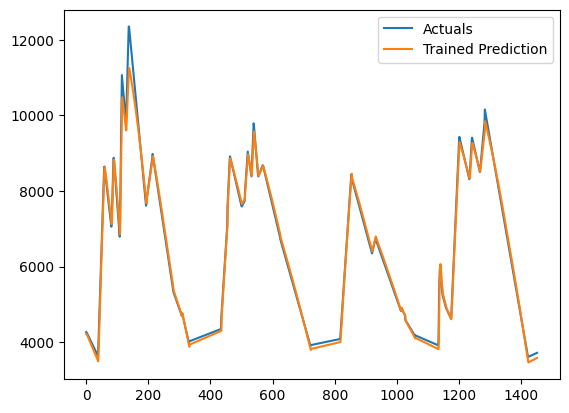

In [15]:
import matplotlib.pyplot as plt

plt.plot(results['Actuals'])
plt.plot(results['Trained Prediction'])
plt.legend(results, loc= "upper right")

In [16]:
from sklearn.metrics import r2_score

true = results['Actuals']
predicted = results['Trained Prediction']

r2_score(true, predicted)

0.9938056468963623

In [17]:
valid_predict= models.predict(x_val).flatten()
results=pd.DataFrame(data={"Trained Prediction":valid_predict, "Actuals":y_val})
results

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Trained Prediction,Actuals
0,5178.661621,5131
1,5153.042969,5108
2,5128.458984,5084
3,5102.770508,5061
4,5078.119141,5038
...,...,...
447,3568.980713,3705
448,3573.546631,3709
449,3578.112305,3712
450,3581.535889,3716


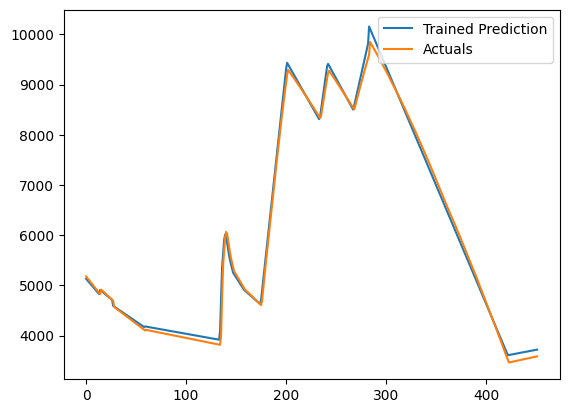

In [18]:
plt.plot(results['Actuals'])
plt.plot(results['Trained Prediction'])
plt.legend(results, loc= "upper right")